In [1]:
'''
ML model to support approve/deny decision for credit card loan

Notes:
- sensitive variable: gender (other examples are race, and ethnicity)
- fairness metrics: demographic parity, equal opportunity, and equal accuracy 

References:
- https://www.kaggle.com/code/alexisbcook/exercise-ai-fairness
'''

'\nML model to support approve/deny decision for credit card loan\n\nNotes:\n- sensitive variable: gender (other examples are race, and ethnicity)\n- fairness metrics: demographic parity, equal opportunity, and equal accuracy \n\nReferences:\n- https://www.kaggle.com/code/alexisbcook/exercise-ai-fairness\n'

# import

In [2]:
import pandas as pd
import numpy as np
import mlflow
import logging
import joblib, datetime, os, time, yaml
from os import environ as env
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# configure

In [3]:
# harness
'''
Harness CI Runner can automatically change values for some variable
For example is_local_development to False and tree_method to hist
'''
is_local_development = True 
notebook_dir = 'notebooks'
config_file_path = 'config.yml'
model_name = 'dt'

In [4]:
# set working dir
original_cwd = os.getcwd()

if not is_local_development:
    
    os.chdir(notebook_dir)
    os.getcwd()
    
print(os.getcwd())

/Users/shobhitverma/python/example-mlops/raghav


In [5]:
# set logging
logging.basicConfig(level=logging.INFO, format="%(asctime)-15s %(message)s")
logger = logging.getLogger()

In [6]:
# set parameters
with open(config_file_path, "r") as file:
    config = yaml.safe_load(file)

# set model related parameters
data_file_path = config['data']['load_file_path']
selected_model_file_path = config['model']['save_file_path']
selected_model_metrics_file_path = config['model']['save_metrics_file_path']

# set MLFlow related parameters
experiment_name = config["mlflow"]["experiment_name"]
run_name = config["mlflow"]["run_name"]

# experiment

In [7]:
# load data

data = pd.read_csv(data_file_path)
X = data.drop(["Target"], axis=1)
y = data["Target"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Data successfully loaded!\n")
X_train.head()

Data successfully loaded!



,Num_Children,Group,Income,Own_Car,Own_Housing
288363,1,1,40690,0,1
64982,2,0,75469,1,0
227641,1,1,70497,1,1
137672,1,1,61000,0,0
12758,1,1,56666,1,1


In [8]:
# define metrics

# confusion matrix
def get_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=display_labels)
    disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)
    return matrix, disp

# fairness
def get_fairness_stats(X, y, model, group_one, preds):
    fairness_stats = {}
        
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    cm, disp = get_confusion_matrix(model, X, y, preds)
    disp.ax_.set_title("Overall")
    cm_zero, disp_zero = get_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group 0")
    cm_one, disp_one = get_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group 1")
    
    fairness_stats['demographic_parity'] = {'total_number_of_approvals': preds.sum(), 
                                            'group_0_%': round(preds_zero.sum()/sum(preds)*100, 2),
                                            'group_1_%': round(preds_one.sum()/sum(preds)*100, 2)}         
    fairness_stats['equal_opportunity'] = {'true_positive_rate': round(cm_zero[1,1] / cm_zero[1].sum()*100, 2),
                                           'group_0_%': round(cm_zero[1,1] / cm_zero[1].sum()*100, 2),
                                           'group_1_%': round(cm_one[1,1] / cm_one[1].sum()*100, 2)}
    fairness_stats['equal_accuracy'] = {'overall_accuracy': round((preds==y).sum()/len(y)*100, 2),
                                        'group_0_%': round((preds_zero==y_zero).sum()/len(y_zero)*100, 2),
                                        'group_1_%': round((preds_one==y_one).sum()/len(y_one)*100, 2)}
    fairness_stats['confusion_matrix'] = {'overall_confusion_matrix': cm.tolist(), 
                                          'group_0': cm_zero.tolist(),
                                          'group_1': cm_one.tolist()}
    return fairness_stats

def get_metrics(y_true, y_pred):
    metrics = {}
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    return metrics

# feature importance
def get_feature_importances(X, y):
    feature_names = X.columns
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using Mean Decrease in Impurity")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [9]:
# baseline model

# train
model_baseline = DecisionTreeClassifier(random_state=0, max_depth=3)
model_baseline.fit(X_train, y_train)

# predict
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

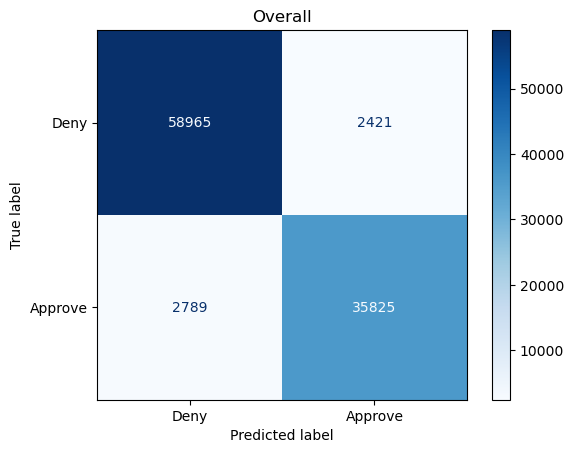

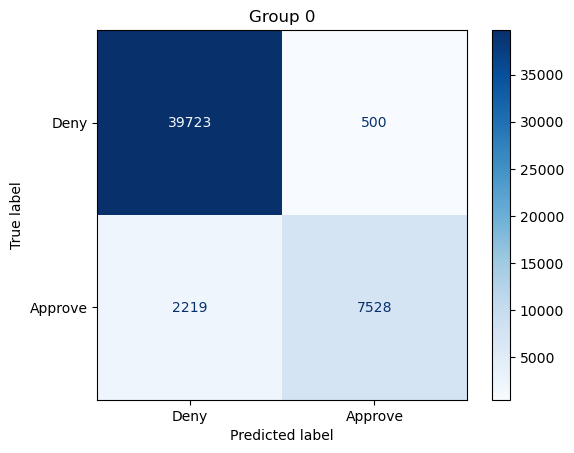

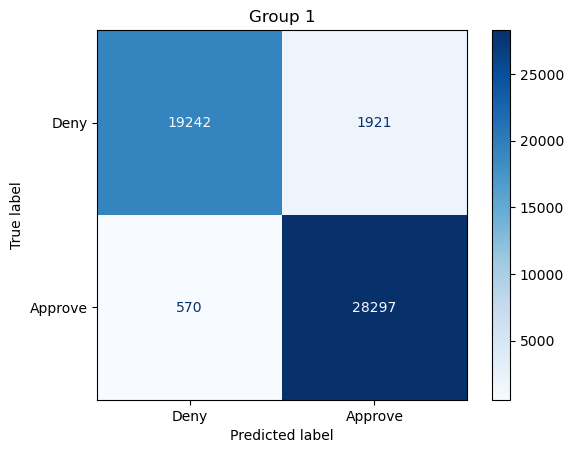

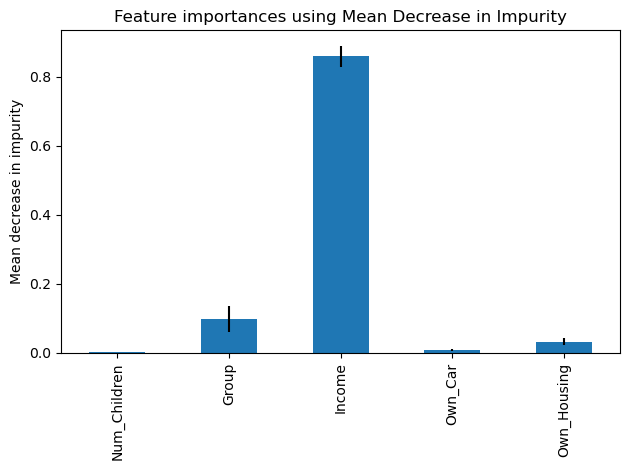

In [10]:
# metrics

train_metrics = get_metrics(y_train, y_train_pred)
test_metrics = get_metrics(y_test, y_test_pred)

fairness_metrics = get_fairness_stats(X_test, y_test, model_baseline, X_test["Group"]==1, y_test_pred)
feature_importances = get_feature_importances(X_train, y_train)

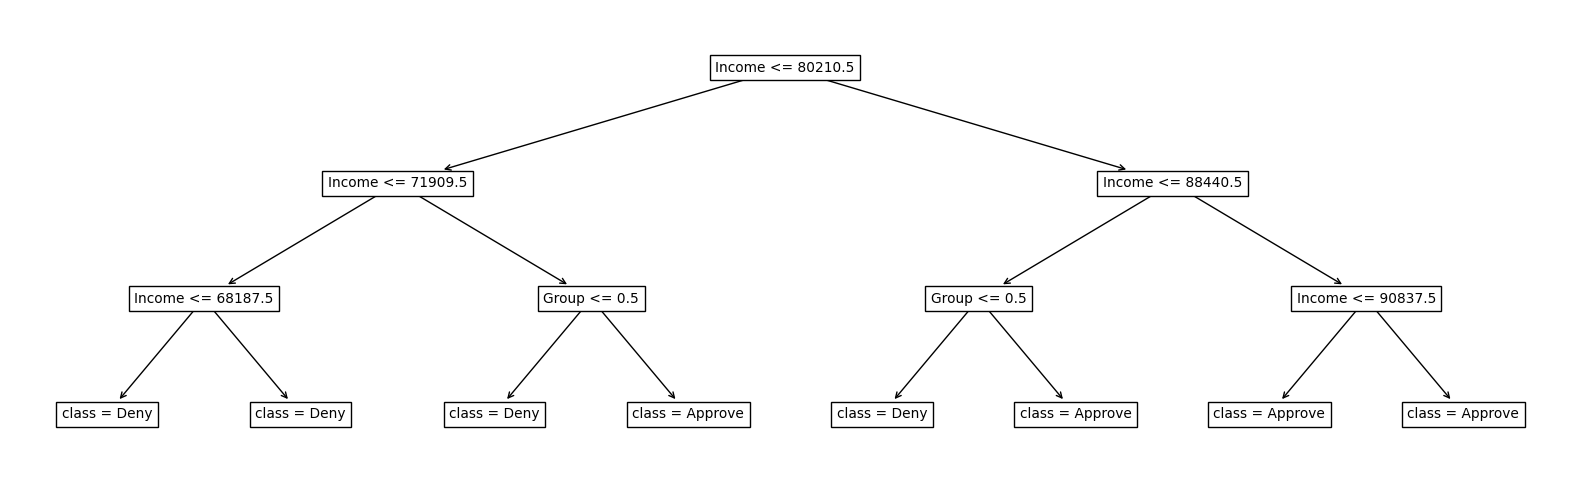

In [11]:
def visualize_model(model, feature_names, class_names=["Deny", "Approve"], impurity=False):
    plot_list = plot_tree(model, feature_names=feature_names, class_names=class_names, impurity=impurity)
    [process_plot_item(item) for item in plot_list]

def process_plot_item(item):
    split_string = item.get_text().split("\n")
    if split_string[0].startswith("samples"):
        item.set_text(split_string[-1])
    else:
        item.set_text(split_string[0])

plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_baseline, feature_names=X_train.columns)

In [12]:
# gender unaware model

# remove gender
X_train_unaware = X_train.drop(["Group"],axis=1)
X_test_unaware = X_test.drop(["Group"],axis=1)

# train
model_unaware = DecisionTreeClassifier(random_state=0, max_depth=3)
model_unaware.fit(X_train_unaware, y_train)

# predict
y_train_unaware_pred = model_unaware.predict(X_train_unaware)
y_test_unaware_pred = model_unaware.predict(X_test_unaware)

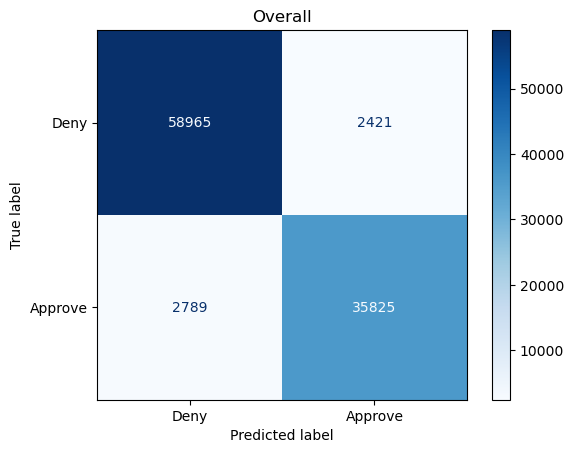

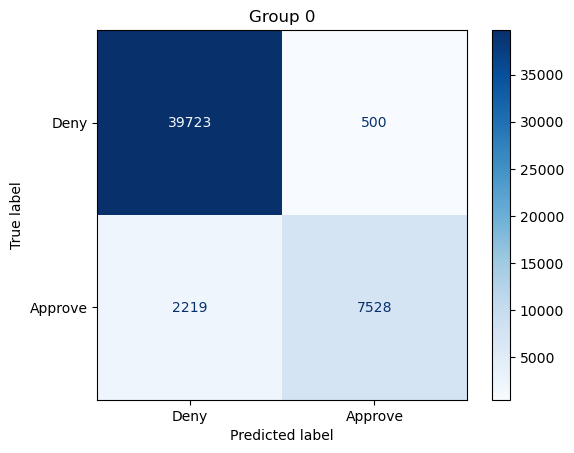

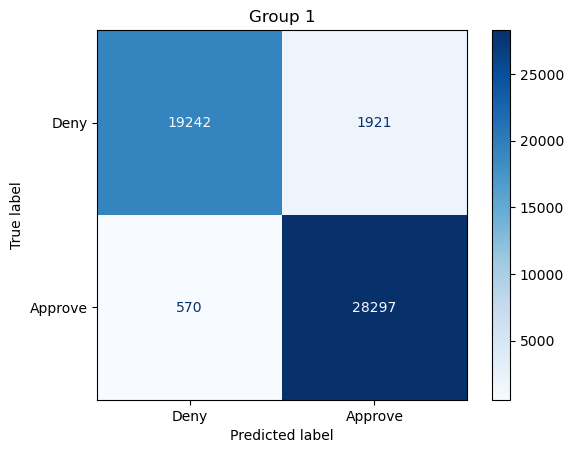

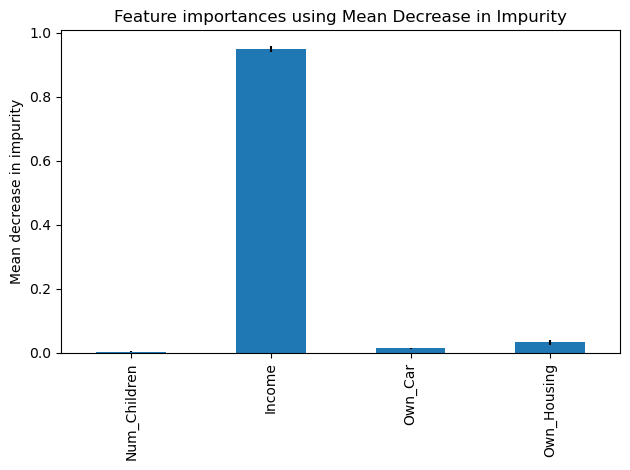

In [13]:
# metrics

train_metrics = get_metrics(y_train, y_train_unaware_pred)
test_metrics = get_metrics(y_test, y_test_unaware_pred)

fairness_metrics = get_fairness_stats(X_test, y_test, model_unaware, X_test["Group"]==1, y_test_pred)

feature_importances = get_feature_importances(X_train_unaware, y_train)

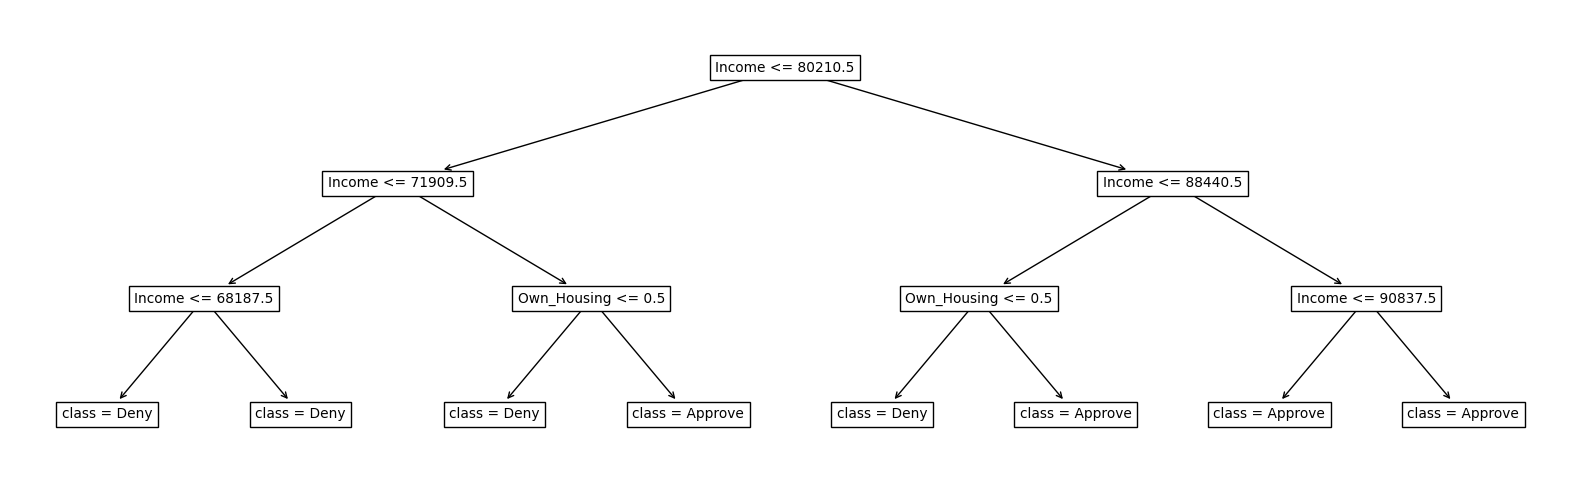

In [14]:
plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_unaware, feature_names=X_train_unaware.columns)

{'demographic_parity': {'total_number_of_approvals': 38241,
  'group_0_%': 51.96,
  'group_1_%': 48.04},
 'equal_opportunity': {'true_positive_rate': 100.0,
  'group_0_%': 100.0,
  'group_1_%': 63.64},
 'equal_accuracy': {'overall_accuracy': 79.38,
  'group_0_%': 79.74,
  'group_1_%': 79.02},
 'confusion_matrix': {'overall_confusion_matrix': [[51264, 10122],
   [10495, 28119]],
  'group_0': [[30101, 10122], [0, 9747]],
  'group_1': [[21163, 0], [10495, 18372]]}}

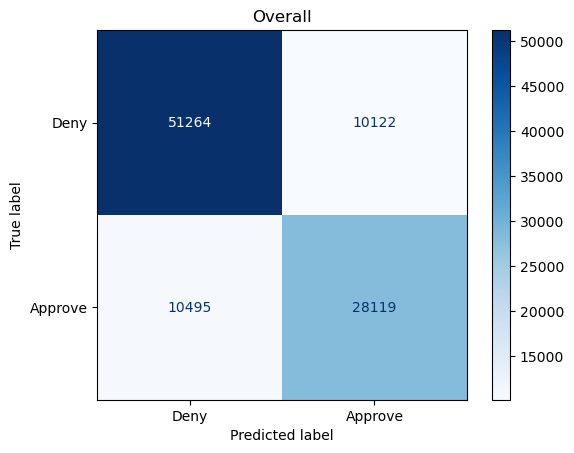

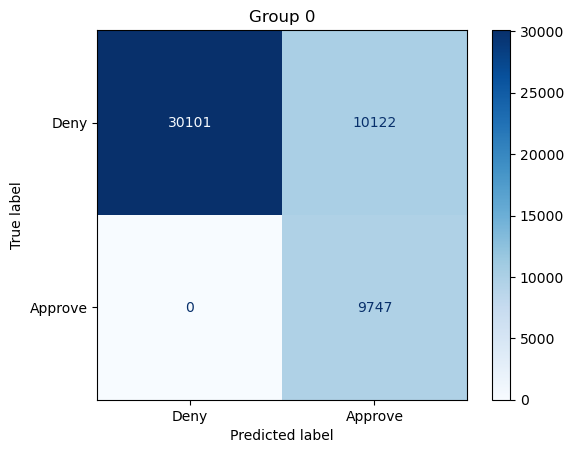

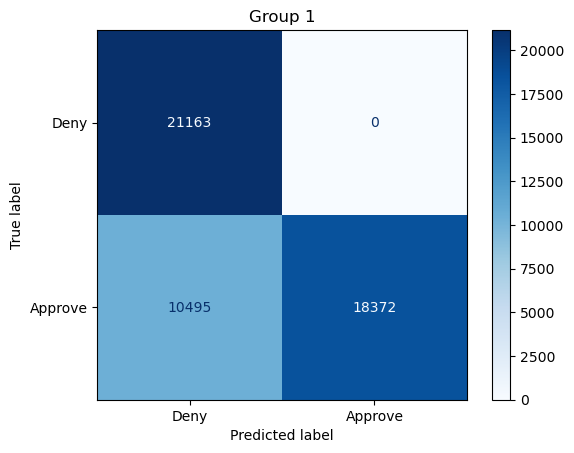

In [15]:
# threshold finetuning to further mitigate bias

zero_threshold = 0.11
one_threshold = 0.99

# predict
test_probs = model_unaware.predict_proba(X_test_unaware)[:,1]
preds_approval = (((test_probs>zero_threshold)*1)*[X_test["Group"]==0] + ((test_probs>one_threshold)*1)*[X_test["Group"]==1])[0]
get_fairness_stats(X_test, y_test, model_unaware, X_test["Group"]==1, preds_approval)

# save 

In [16]:
# save selected model and metrics
selected_model = model_unaware
selected_model_metrics = {'train': train_metrics,
                          'test': test_metrics,
                          'fairness': fairness_metrics,
                          'feature_importances': feature_importances}

joblib.dump(selected_model, selected_model_file_path)
joblib.dump(selected_model_metrics, selected_model_metrics_file_path)

['selected_model_metrics.joblib']

# track

In [17]:
# track experiment 
mlflow.set_experiment(experiment_name)
mlflow.start_run(run_name=run_name)

mlflow.log_params(
    {
        "model_type": model_name,
        "n_features": X.shape[1],
        "feature_importances": feature_importances
    }
)

mlflow.log_metric('train_f1', selected_model_metrics['train']['f1'])
mlflow.log_metric('test_f1', selected_model_metrics['test']['f1'])
   
mlflow.log_artifact(f"{selected_model_file_path}")

mlflow.end_run()

# test

In [18]:
selected_model_metrics = joblib.load(selected_model_metrics_file_path)

In [19]:
# model accuracy
threshold_accuracy = 0.9
accuracy = selected_model_metrics['test']['accuracy']
assert accuracy > threshold_accuracy, 'accuracy {} is below {}'.format(accuracy, threshold_accuracy)

In [20]:
# fairness
equal_opportunity_fairness_threshold_percent = 21
equal_opportunity_group_0_percent = selected_model_metrics['fairness']['equal_opportunity']['group_0_%']
equal_opportunity_group_1_percent = selected_model_metrics['fairness']['equal_opportunity']['group_1_%']
assert abs(equal_opportunity_group_0_percent - equal_opportunity_group_1_percent) < equal_opportunity_fairness_threshold_percent, 'difference exceeds {}%'.format(equal_opportunity_fairness_threshold_percent)

In [21]:
import sys
modulenames = set(sys.modules) & set(globals())
allmodules = set([sys.modules[name] for name in modulenames]) 


In [22]:
list(map(lambda x: (x.__name__, x.__version__) if x.__name__ not in  set(['os', 'time', 'datetime', 'sys']) else '', allmodules))

['',
 '',
 ('joblib', '1.2.0'),
 '',
 ('logging', '0.5.1.2'),
 ('mlflow', '2.9.2'),
 ('yaml', '6.0.1'),
 '']

In [23]:
mlflow.__name__

'mlflow'

In [24]:
np.__version__

'1.26.3'

In [25]:
import sklearn


In [26]:
sklearn.__version__

'1.2.2'

In [27]:
pd.__version__

'1.5.3'